# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
!pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163768 sha256=131bfa46318d6af816c4bae0fd6bf2d3d4bfda977d4ab9fe07fa0d1d40cde9e3
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# CF

In [5]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import operator


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/ratings_Beauty.csv')

In [7]:
#Checking Data
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [8]:
df.nunique()

UserId       1210271
ProductId     249274
Rating             5
Timestamp       4231
dtype: int64

In [9]:
# Encode User IDs
label_encoder = LabelEncoder()
df['EncodedUserId'] = label_encoder.fit_transform(df['UserId'])

In [10]:
# Map Product IDs to Numeric Representation
product_mapping = {product_id: index + 1 for index, product_id in enumerate(df['ProductId'].unique())}
df['EncodedProductId'] = df['ProductId'].map(product_mapping)

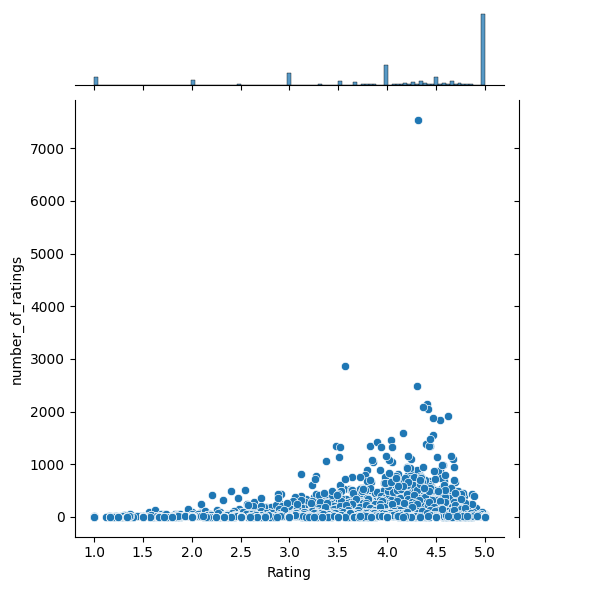

In [11]:
# Data Exploration
ratings = pd.DataFrame(df.groupby('EncodedProductId')['Rating'].mean())
ratings['number_of_ratings'] = df.groupby('EncodedProductId')['Rating'].count()

# Plotting
sns.jointplot(x='Rating', y='number_of_ratings', data=ratings)

In [12]:
# Calculate Average Ratings by User
average_rating = df.groupby(by="EncodedUserId", as_index=False)['Rating'].mean()

In [13]:
# Merge with the dataset
df = pd.merge(df, average_rating, on="EncodedUserId")
df = df.rename(columns={"Rating_x": "real_rating", "Rating_y": "average_rating"})

In [14]:
# Adjust Ratings
df['normalized_rating'] = df['real_rating'] - df['average_rating']

In [15]:
# Filter Popular Products
rating_of_product = df.groupby('EncodedProductId')['real_rating'].count()
ratings_of_products_df = pd.DataFrame(rating_of_product)
filtered_ratings_per_product = ratings_of_products_df[ratings_of_products_df.real_rating >= 200]
popular_products = filtered_ratings_per_product.index.tolist()
filtered_ratings_data = df[df["EncodedProductId"].isin(popular_products)]

In [16]:
# User Similarity
similarity = pd.pivot_table(filtered_ratings_data, values='normalized_rating', index='EncodedUserId', columns='EncodedProductId')
similarity = similarity.fillna(0)

In [17]:
# Get Top 5 Similar Users
selecting_users = list(similarity.index)
selecting_users = selecting_users[:100]

In [18]:
def get_top_5_similar_users(user_id, similarity_table, k=5):
    user = similarity_table[similarity_table.index == user_id]
    other_users = similarity_table[similarity_table.index != user_id]
    similarities = cosine_similarity(user, other_users)[0].tolist()
    indices = other_users.index.tolist()
    index_similarity = dict(zip(indices, similarities))

    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1), reverse=True)
    top_users_similarities = index_similarity_sorted[:k]
    users = [user[0] for user in top_users_similarities]

    return users


In [19]:
df.head()

,UserId,ProductId,real_rating,Timestamp,EncodedUserId,EncodedProductId,average_rating,normalized_rating
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,725046,1,4.25,0.75
1,A39HTATAQ9V7YF,B002OVV7F0,3.0,1369699200,725046,81855,4.25,-1.25
2,A39HTATAQ9V7YF,B0031IH5FQ,5.0,1369699200,725046,89014,4.25,0.75
3,A39HTATAQ9V7YF,B006GQPZ8E,4.0,1369699200,725046,154093,4.25,-0.25
4,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,814606,2,3.50,-0.50


In [20]:
user_id = 11
similar_users = get_top_5_similar_users(user_id, similarity)
print(f"Top 5 similar users for user_id {user_id}: {similar_users}")

Top 5 similar users for user_id 11: [13034, 22958, 23345, 90399, 125548]


# CF SVD

In [21]:
# Import Surprise
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

In [22]:
# Create Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['EncodedUserId', 'EncodedProductId', 'real_rating']], reader)

In [23]:
# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=30)

In [24]:
# Create and train the SVD model
svd_model = SVD(n_factors=50, random_state=42)
svd_model.fit(trainset)

In [25]:
# Evaluate the model
predictions = svd_model.test(testset)
accuracy = rmse(predictions)
print(f'RMSE: {accuracy}')

RMSE: 1.2496
RMSE: 1.2495614422754493


In [26]:
# Get Top N Recommendations for a User
def get_top_n_recommendations(user_id, model, n=5):
    all_products = df['EncodedProductId'].unique()
    user_products = df[df['EncodedUserId'] == user_id]['EncodedProductId'].unique()

    unrated_products = np.setdiff1d(all_products, user_products)

    testset = [[user_id, product_id, 4.0] for product_id in unrated_products]
    predictions = model.test(testset)

    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    top_n_products = [prediction.iid for prediction in top_n]

    return top_n_products

In [27]:
# Example: Get Top 5 Recommendations for User 11
user_id = 11
top_recommendations = get_top_n_recommendations(user_id, svd_model, n=5)
print(f"Top 5 recommendations for user_id {user_id}: {top_recommendations}")


Top 5 recommendations for user_id 11: [87392, 114686, 110874, 33869, 204542]


In [28]:
# Example: Get Top 5 Recommendations for User 60
user_id = 60
top_recommendations = get_top_n_recommendations(user_id, svd_model, n=5)
print(f"Top 5 recommendations for user_id {user_id}: {top_recommendations}")


Top 5 recommendations for user_id 60: [112340, 148421, 114686, 116170, 114624]
